<a href="https://colab.research.google.com/github/RoseSarlake/Computer-Vision/blob/main/CV_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import needed packages

In [1]:
import numpy as np
import cv2
import math
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

In [2]:
# import drive to access the test images
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


some functions from assignment 1 

In [3]:
# Gaussian kernel
def My_Gaussian(size,sigma):
  w = size 
  hw = (w-1)/2
  sum = 0
  g = np.zeros(w)
  for i in range(0,w):
    # The continuous normalization factor can be ignored since it disappears in the discrete normalization step
    g[i] = math.exp(-((i-hw)*(i-hw))/(2*sigma*sigma))
    sum += g[i]
  for i in range(0,w):
    g[i] /= sum
  return g

In [4]:
def My_convolve2D(image, kernel, padding=0):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # get the image size and kernel size 
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int((xImgShape - xKernShape + 2 * padding) + 1)
    yOutput = int((yImgShape - yKernShape + 2 * padding) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply mirror padding
    if padding != 0:
        imagePadded = cv2.copyMakeBorder(image,padding,padding,padding,padding,cv2.BORDER_REFLECT)
        #print(imagePadded)
    else:
        imagePadded = image

    # Convolution
    for y in range(image.shape[1]):
        for x in range(image.shape[0]):
          output[x, y] = (kernel * imagePadded[x:x+xKernShape,y:y+yKernShape]).sum()
    return output

# 1.Harris derector

a) Assume 𝜎0 = 0.5 as the smoothing of the input image. Compute the first derivative matrixes (Ix ,Iy) at a scale 𝜎𝐷 = 1.4𝜎0 . Differential masks of size 2 can be used.

In [5]:
def my_harris_dxdy (sigma,img):
  # convert the input image to gray level 
  img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

  # calculate the smoothing kernel 
  kerv1 = My_Gaussian(5,sigma)
  # reverse it
  kerh1 = kerv1.reshape(kerv1.shape[0],1)
  # calculate the final 2d gaussian kernel
  kernel = kerv1*kerh1

  #smooth the image with the above kernel
  img_smooth = My_convolve2D(img_gray,kernel,padding=2)

  #  compute the first derivative
  Idx,Idy = np.gradient(img_smooth)

  # create a new kernel
  kerv2 = My_Gaussian(5,1.4*sigma)
  kerh2 = kerv2.reshape(kerv2.shape[0],1)
  kernel2 = kerv2*kerh2
  # smooth again, sigmaD = 1.4sigma0
  Ix = My_convolve2D(Idx,kernel2,padding=2)
  Iy = My_convolve2D(Idy,kernel2,padding=2)

  return Ix,Iy


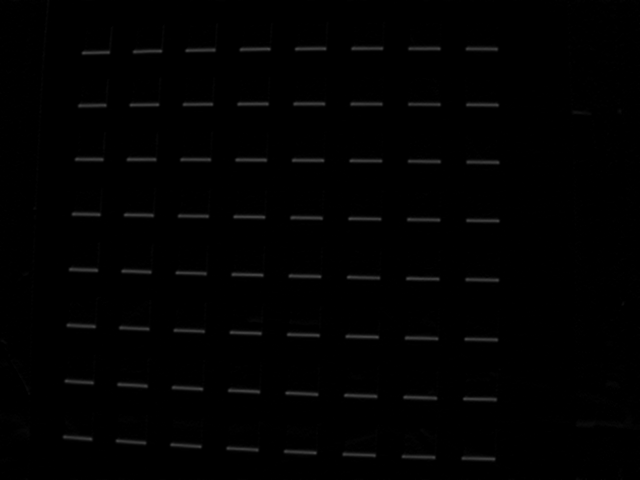

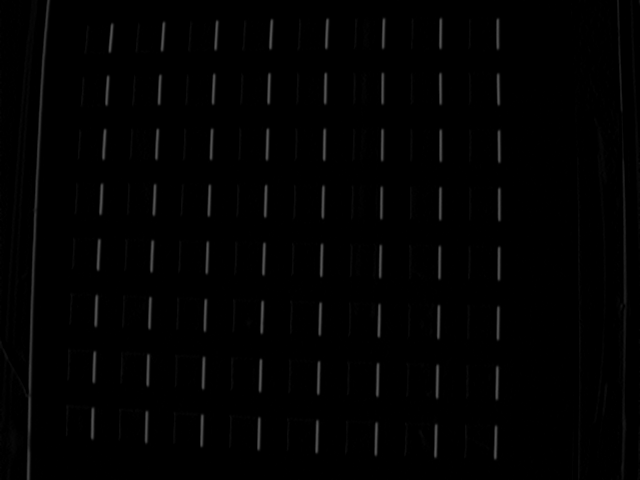

In [6]:
# read a img
img1 = cv2.imread("/content/drive/MyDrive/Colab/CV/images/CalibIm1.PNG")

# call the function my_harris_dxdy, store the result in dx1,dy1
dx1,dy1 = my_harris_dxdy(0.5,img1)
# show the result
cv2_imshow(dx1)
cv2_imshow(dy1)

b) Compute the three matrixes: Ix2, Iy2, IxIy

In [7]:
# from Idx,Idy in the 1 a), Ixx, Iyy, Ixy, Iyx  can be compute by numpy. 
def My_harris_xy(sigma,img):
  # call function my_harris_dxdy to get the dx and dy
  dx,dy = my_harris_dxdy (sigma,img)
  # Ix2 is the suqare of dx
  Ixx = np.square(dx)
  # Iy2 is the suqare of dy
  Iyy = np.square(dy)
  # (because Ixy == Iyx, only one need to be calculated)
  Ixy = np.multiply(dx,dy)
  
  return Ixx, Iyy, Ixy


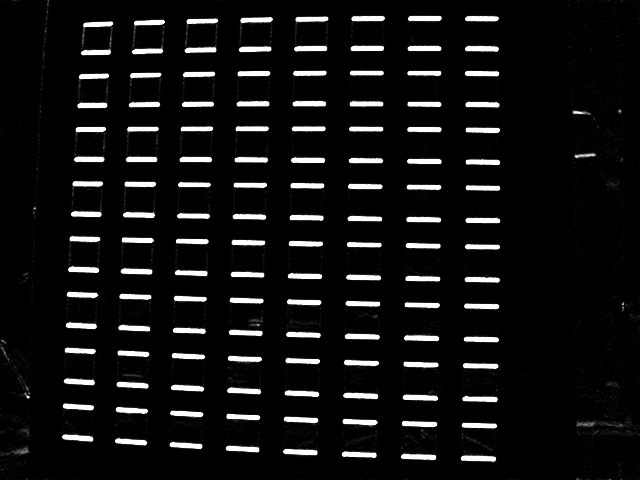

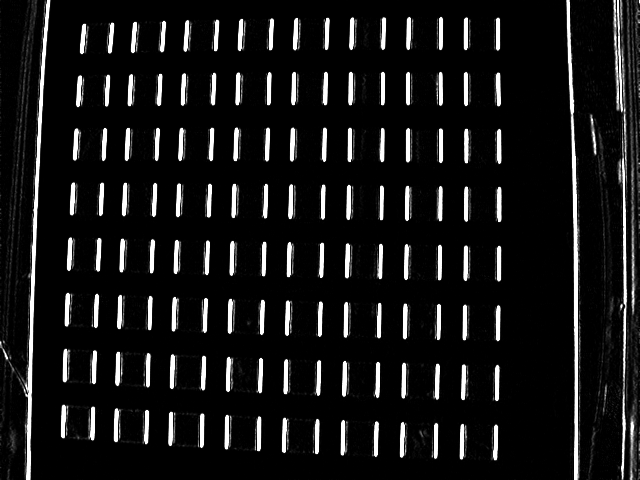

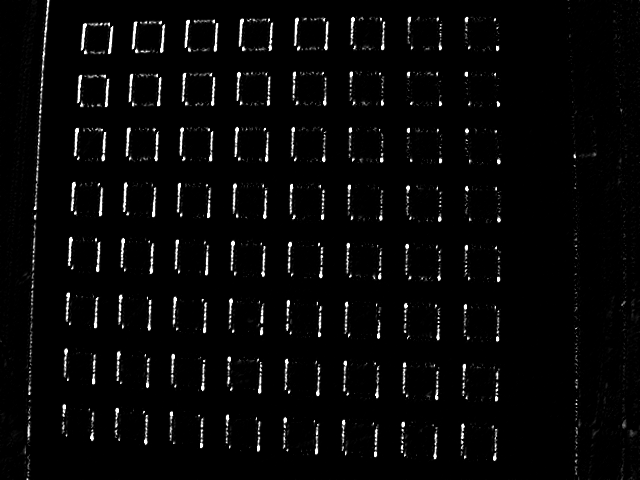

In [8]:
# call the function My_harris_xy, store all three values as ixx, iyy and ixy
ixx,iyy,ixy = My_harris_xy(0.5,img1)
# show the result
cv2_imshow(ixx)
cv2_imshow(iyy)
cv2_imshow(ixy)

c) Compute at each pixel the terms of the second moment matrix by convolving the three matrices in point (c) with an isotropic Gaussian of 𝜎𝐼 = 1.5𝜎𝐷. Compute Trace and Determinant in each pixel

In [9]:
def My_harris_3mat(sigma,img):
  # call function My_harris_xy to get Ixx, Iyy and Ixy value
  Ixx,Iyy,Ixy = My_harris_xy(sigma,img)
  # create a new gaussian kernel, where sigmaI = 1.5sigmaD
  kerv = My_Gaussian(5,sigma*1.4*1.5)
  kerh = kerv.reshape(kerv.shape[0],1)
  kernel = kerv*kerh

  # convolve the three matrices in point (c) with the kernel above
  Imgxx = My_convolve2D(Ixx, kernel, padding=2)
  Imgyy = My_convolve2D(Iyy, kernel, padding=2)
  Imgxy = My_convolve2D(Ixy, kernel, padding=2)

  return Imgxx, Imgyy, Imgxy

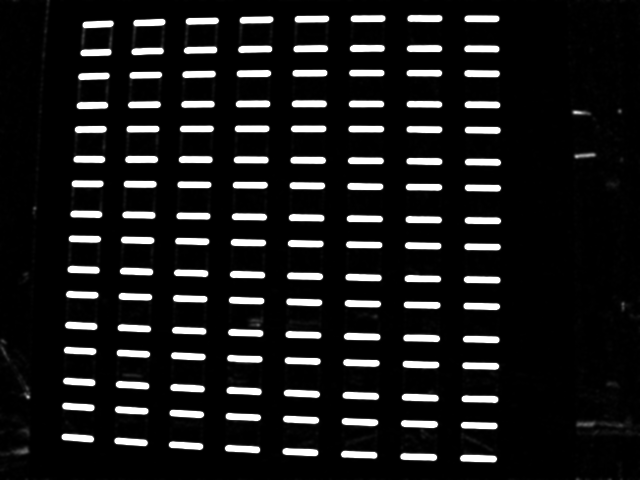

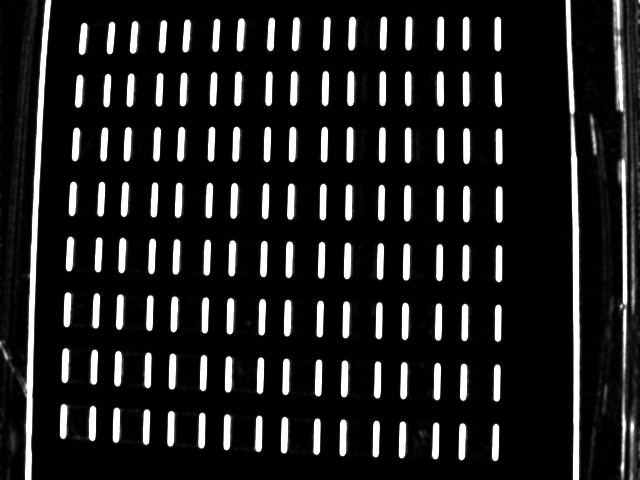

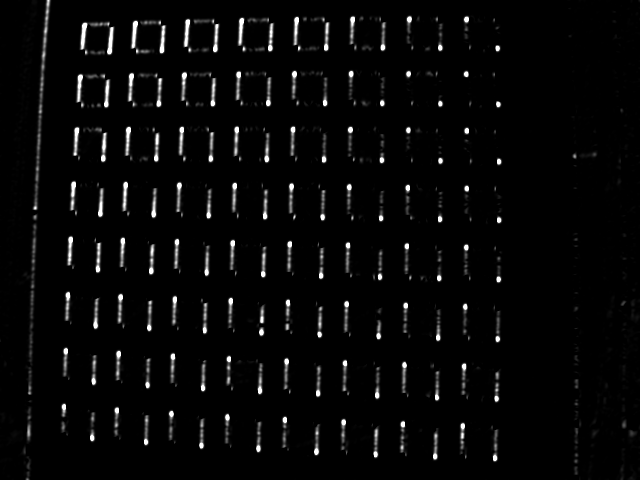

In [10]:
# call the function My_harris_3mat, store all three values as imgxx, imgyy, imgxy
imgxx, imgyy, imgxy = My_harris_3mat(0.5,img1)
# show the result
cv2_imshow(imgxx)
cv2_imshow(imgyy)
cv2_imshow(imgxy)

In [11]:
def My_harris_sqmat(sigma,img):
# call My_harris_3mat to get the filtered Imgxx, Imgyy and Imgxy
  Imgxx, Imgyy, Imgxy = My_harris_3mat(sigma,img)
  # imitialize variable res to store Harris-values
  res = np.zeros((img.shape[0],img.shape[1]),np.float32)
  # assume the k value is 0.04, 
  k = 0.04

  # for each pixel, calculate the second-moment matrix
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      # store the result in an array, which is a 2*2 matrix as follow:
      #   [Imgxx, Imgxy]
      #   [Imgxy, Imgyy]
      mat = np.array([[Imgxx[i][j], Imgxy[i][j]], 
               [Imgxy[i][j], Imgyy[i][j]]])
      # compute trace, which is the sum of Imgxx + sum of Imgyy
      # In numpy, "matrix.trace" can return the sum along diagonals of an array.
      trace = np.matrix.trace(mat)
      # compute determinant, which is the (sum of Imgxx * sum of Imgyy) - (sum of Imgxy**2)
      # In numpy, "linalg.det" can help to compute the determinant of an array
      deter = np.linalg.det(mat)

      # calculate the final response: res = deter - k*(trace**2)
      res[i][j]= deter - (k*np.square(trace))
      
  return res

d) Apply the Harris-corner criteria to compute the Harris-feature map

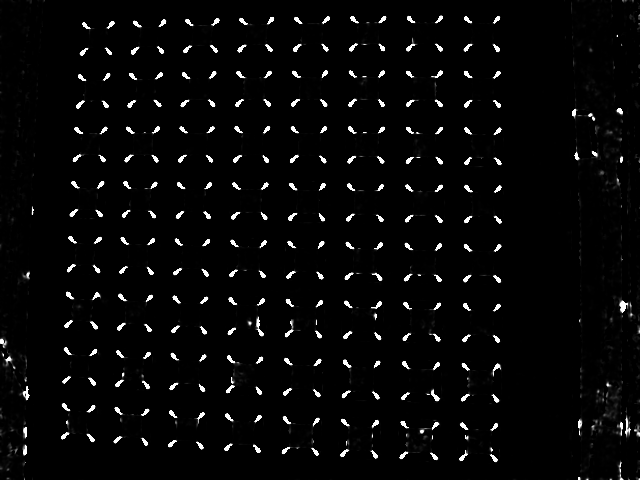

In [12]:
# The final responses are computed in the 1 c)- My_harris_sqmat function, here apply it in a test image
feature = My_harris_sqmat(0.5,img1)
# show the image
cv2_imshow(feature)

e) Apply Non-Maxima suppression to identify true Harris points. Use 5 pixels as the minimum distance between maxima.

In [13]:
# function that return the max value and its location
def My_harris_max(block):
  # In this function, assume the block is always 5*5

  # initialize the max value as center value of the block, and its location
  max = block[2][2]
  x = 2
  y = 2
# loop all the block to find the max value
  for i in range(0,5):
    for j in range(0,5):
      # if the current value is larger than max, store its location and value
      if block[i][j] > max:
        max = block[i][j]
        x = i
        y = j
  return x, y, max

In [14]:
# Non-Maxima suppression is used to restrict the minimum distance between adjacent Harris locations
# For example, if the mask size is 5*5, then in the 5*5 area, only one detected value can be stored


# input value "feat" is the feature map, "size" is the size*size empty mask
def My_harris_nonMax(feat,size):

 # get the feature image size
  height = feat.shape[0]
  width = feat.shape[1]
  # save the location of the detected point
  points = []
  # calculate the half size of mask size, which determine which pixel to start with
  hs = int(np.floor(size/2))

  # slide the mask into the feature image, with the step as same as mask size 
  # (because only one value need to be store in each block location, so do not need to slide on image pixel one by one)
  
  for i in range(hs,width-hs-1,size):
    for j in range(hs,height-hs-1,size):
      # get the current block 
      block_cur = feat[j-hs:j+hs+1,i-hs:i+hs+1]
      # call the My_harris_max function to find the max value of the current block
      x, y, max = My_harris_max(block_cur)
      # calculate the global location from the local location
      col = i + x - hs
      row = j + y - hs
      # store the result in the prepared list
      points.append((row, col, max))
     
  return points


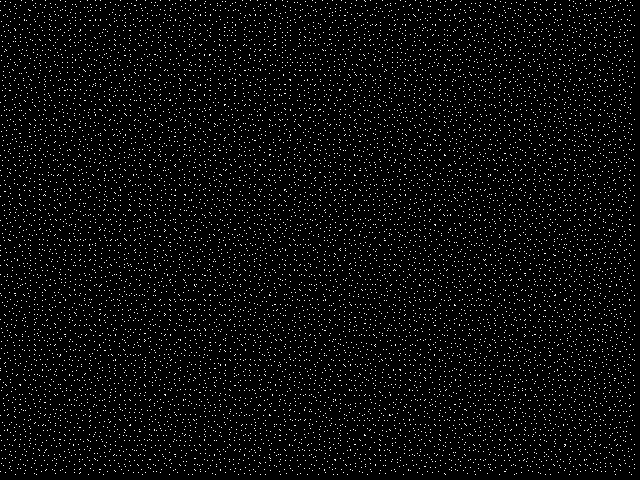

In [15]:
# call the function My_harris_nonMax, generate the location list
point = My_harris_nonMax(feature,5)
# generate a black image with the same size of the feature
blk = np.zeros((feature.shape[0],feature.shape[1]),np.float32)
# set the point in selected location as 255, which will show as white point in the image
for i in range(len(point)):
  blk[point[i][0],point[i][1]] = 255
# show the result
cv2_imshow(blk)
# obviously, there's too many points, because in every 5*5 block, there's one max point

f) Sort the local maxima to decrease the order of Harris-value and go through the list eliminating the weaker points at a distance less than a given threshold of one with a higher value 

In [16]:
# define a global variable THRESHOLD as the threshold of the Harris-value
THRESHOLD = 20 

In [17]:
# This is the improvement version of the funtion "My_harris_max", add a threshold to remove the weaker points

# input value "feat" is the feature map, "size" is the size*size empty mask
def My_harris_nonMax(feat,size):

 # get the feature image size
  height = feat.shape[0]
  width = feat.shape[1]
  # save the location of the detected point
  points = []
  # calculate the half size of mask size, which determine which pixel to start with
  hs = int(np.floor(size/2))

  # slide the mask into the feature image, with the step as same as mask size 
  # (because only one value need to be store in each block location, so do not need to slide on image pixel one by one)
  
  for i in range(hs,width-hs-1,size):
    for j in range(hs,height-hs-1,size):
      # get the current block 
      block_cur = feat[j-hs:j+hs+1,i-hs:i+hs+1]
      # call the My_harris_max function to find the max value of the current block
      x, y, max = My_harris_max(block_cur)
      # if the current value is larger than max, store its location and value
      if max > THRESHOLD:
      # calculate the global location from the local location
        col = i + x - hs
        row = j + y - hs
      # store the result in the prepared list
        points.append((row, col, max))
      # if the value is lower than the threshold, ignore it
      else:
        pass
  return points


In [18]:
point_thre = My_harris_nonMax(feature,5)
# the number of detected points decrease a lot
print(len(point))
print(len(point_thre))

12065
1815


g) Fix a threshold to keep only with the first 1000 highest values.

In [19]:
# define how many highest values need to keep, here set the HIVAL = 1000
HIVAL = 1000

def My_harris_highset(feat,size):
  # call function My_harris_nonMax to get the detected points list
  pointlist = My_harris_nonMax(feat,size)
  # the point list store as [(x1,y1,harris_val1),(x2,y2,harris_val2),(x3,y3,harris_val3)...] 
  # each tuple of the list is the point's (x-axis,y-axis,harris value)
  # sort the tuple list from the highest to lowest based on the the harris value (tuple index 2)
  sortlist = sorted(pointlist, key = lambda tup : tup[2], reverse=True)
  # slice the sorted list, only keep the highest points 
  slicelist = sortlist[0:HIVAL]

  return slicelist


1000


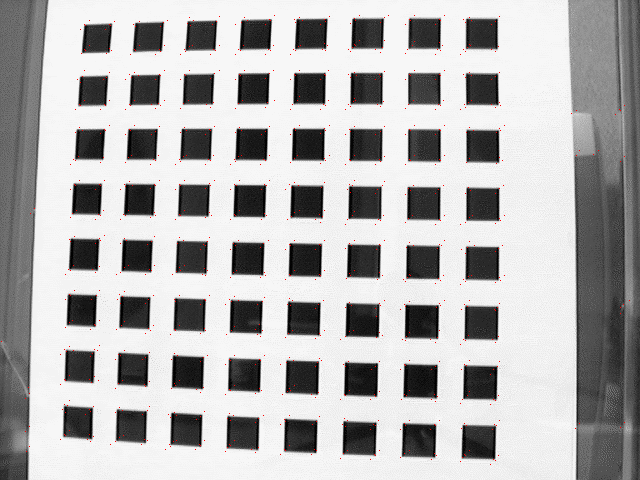

In [20]:
# call the function My_harris_highset
point_1000 = My_harris_highset(feature,5)
# check the length of the list, only 1000 points left
print(len(point_1000))

# copy the img1, and save it as img2
img2 = img1.copy()
# set the point in the list "point_1000" as [0,0,255], which will show as red point in the image
for i in range(len(point_1000)):
  img2[point_1000[i][0],point_1000[i][1]] = [0,0,255]
# show the result
cv2_imshow(img2)

h) Refine the spatial coordinates of each KeyPoint using OpenCV's function cornerSubPix on a window of size 5x5.

In [21]:
# in cv2.cornerSubPix function, 5 Parameters are needed: image, corners, windowsize, zero zone and criteria
# The "corner" is require 'numpy.ndarray' class of detected point coordinates
# the "point_1000" is a list with location and max value, need to be prosessed as ndarray class without harris value
print(type(point_1000))

# create a location list to only store location
loc_list=[]
# loop the point_1000 list and get the coordinates
for item in point_1000:
  loc_list.append([item[0],item[1]])

# convert the location list to array
loc_arr = np.asarray(loc_list)
gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
# now the loc_arr can be used in function cornerSubPix()
print(type(loc_arr))
# define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)

# call function cornerSubPix
# store all the refined corner in "corner"
corners = cv2.cornerSubPix(gray,np.float32(loc_arr),(5,5),(-1,-1),criteria)

<class 'list'>
<class 'numpy.ndarray'>


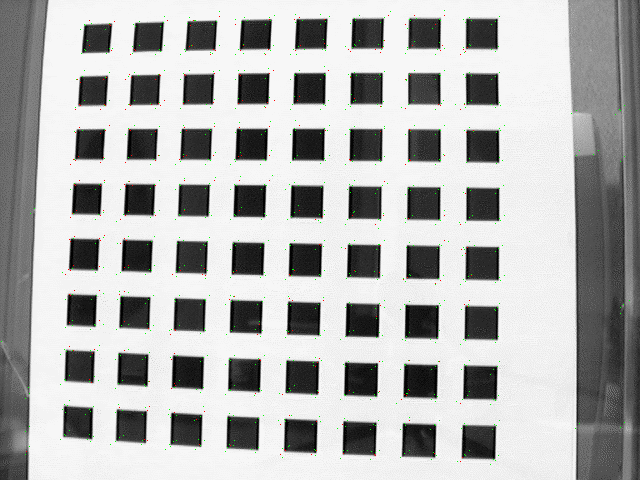

In [22]:
# show the result
# This plot idea is from "OpenCV-Python-Tutroals.readthedocs.io" https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html

# copy the image1 as working image "img_refine"
img_refine = img1.copy()
# stack mypoint list and the refind point list in sequence horizontally
res = np.hstack((loc_arr,corners))
res = np.int0(res)
# the points in my "loc_arr" are shown as red dot
img_refine[res[:,0],res[:,1]]=[0,0,255]
# the refined points from cornerSubPix are shown as green dot
img_refine[res[:,2],res[:,3]] = [0,255,0]
cv2_imshow(img_refine)


# Orientation and Display

a) Extract a signature vector, 𝑆𝑉 = (𝑥, 𝑦, 𝜃, 𝜆1, 𝜆2, 𝜎𝐼), for each Harris-point. Compute the 
region orientation 𝜃 using the angle between the eigenvector associated to the highest eigenvalue (the semi-major axis of the ellipse) and the axis x of the image

In [23]:
# x, y is the output of 1 h), the coordinates of detected point, which stored in "corners"
print(len(corners))
# Lamda1 and lamda2 are the eigenvalues of the SVD of the second moment-matrix;
def My_harris_svd(mat):
  # Compute singular value decomposition
  u,s,vh = np.linalg.svd(mat, full_matrices=True, compute_uv=True, hermitian=False)
  # the two eigenvalues: Lamda1 and lamda2
  #lam1, lam2 = np.square(s)
  lam1, lam2 = s

  return lam1, lam2

1000


In [24]:
# Function that can computer the angle between two vectors
def My_harris_angle(v1,v2):
  # normalize twoo vectors
  uni_v1 = v1/np.linalg.norm(v1)
  uni_v2 = v2/np.linalg.norm(v2)
  # compute the dot product
  dotp = np.dot(uni_v1,uni_v2)
  # compute the angle between two vectors
  angle = np.arccos(dotp)

  return angle

In [25]:
# the acquisition of lam1 and lam2 and theta should in the response computation part

# here is the updated version of function My_harris_sqmat

def My_harris_sqmat(sigma,img):
# call My_harris_3mat to get the filtered Imgxx, Imgyy and Imgxy
  Imgxx, Imgyy, Imgxy = My_harris_3mat(sigma,img)
  # imitialize variable res to store Harris-values
  res = np.zeros((img.shape[0],img.shape[1]),np.float32)
  # assume the k value is 0.04, 
  k = 0.04

  # for each pixel, calculate the second-moment matrix
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      # store the result in an array, which is a 2*2 matrix as follow:
      #   [Imgxx, Imgxy]
      #   [Imgxy, Imgyy]
      mat = np.array([[Imgxx[i][j], Imgxy[i][j]], 
               [Imgxy[i][j], Imgyy[i][j]]])
      # compute trace, which is the sum of Imgxx + sum of Imgyy
      # In numpy, "matrix.trace" can return the sum along diagonals of an array.
      trace = np.matrix.trace(mat)
      # compute determinant, which is the (sum of Imgxx * sum of Imgyy) - (sum of Imgxy**2)
      # In numpy, "linalg.det" can help to compute the determinant of an array
      deter = np.linalg.det(mat)

      # calculate the final response: res = deter - k*(trace**2)
      res[i][j]= deter - (k*np.square(trace))


      # compute the lam1 and lam2 from the matrix
      lam1,lam2 = My_harris_svd(mat)

  # Also, return the lam1 and lam2
  return res, lam1, lam2

i) Show all detected points drawing on the original image circles of radius proportional to the detection scale 𝜎𝐼 with an radio point out to the direction of 𝜃 (Hint: compute KeyPoints and use drawKeyPoints ()).

In [26]:
img_circle = img1.copy()
cv2.drawKeypoints(img_circle, corners, img_circle, color=(255,0,0),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  


TypeError: ignored

j) Show again all detected points but now drawing ellipses instead of circles and using for it the information the first five values of the signature vector. (Hint: use ellipse())

# Region rectification

k) Compute the isometric rectified local regions associated with Harris point integration regions. Use Baumberg’s algorithm and the Cholesky decomposition. Normalize the intensity graylevel to || ||F=1 (Frobenius’s norm)

l) Show in a panel with at least 10 original and rectified regions. As the integrations regions will be too small apply a 10x interpolation to increase the 
size.

# BONUS

m) Construct a four-level Gaussian Scale-space. Assume 𝜎0 = 0.5 𝑎𝑛𝑑 𝜎𝑘 = 1.4 × 𝜎𝑘−1, 𝑘 = 1,2,3,4, as smoothing sigma on each scale. These sigma values fix 
the scale 𝜎𝐷 of the derivative on each level. Apply the above process to all pyramid levels selecting the most representatives regions from each level to a total of 1500. Show the result.